In [59]:
import pandas as pd
from dotenv import load_dotenv
import os
import time
import json
import requests
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates


In [2]:
# Get the fred api key
load_dotenv("keys.env")
fred_api_key = os.getenv("FRED_API_KEY")

# Retrieve FRED Data
### Federal Reserve Economic Data (FRED)
##### Maintained by Federal Reserve Bank of St. Louis 

In [3]:
# Store FRED data in a dictionary
df_dict = {"income": "NCPCPI", "house": "NCSTHPI", "minimum_wage": "STTMINWGNC", "cpi": "CUUR0000SEHA", "mortgage": "MORTGAGE30US", "population": "NCPOP"}

for key, value in df_dict.items():
    try:
        data = requests.get(f"https://api.stlouisfed.org/fred/series/observations?series_id={value}&api_key={fred_api_key}&file_type=json").json()
        df = pd.DataFrame(data['observations'])
        df_dict[key] = df
    except:
        print(f"Problem getting data for {key}: {value}")


In [4]:
df = df_dict['cpi']
df.head()
df.info()
df.isnull().sum()
# df['value'] = df['value'].astype(float)
# df['date'] = df['date'].astype('datetime64[ns]')
# df.head()
# df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1316 entries, 0 to 1315
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   realtime_start  1316 non-null   object
 1   realtime_end    1316 non-null   object
 2   date            1316 non-null   object
 3   value           1316 non-null   object
dtypes: object(4)
memory usage: 41.3+ KB


realtime_start    0
realtime_end      0
date              0
value             0
dtype: int64

# Clean up Data from FRED
## Store the data as csv files in data folder

In [85]:
# Read the CSV files, and store dataframes. Some clean up as well.
def percent_change_column(df):
    """Create a column that shows how much the value has changed overtime"""
    df['changed'] = (df['value'].pct_change() * 100).cumsum().fillna(0)
    return df

def locate_year_df(df):
    """Take a df and return the dataframe within the year 1980-2023"""
    df = df.loc[(df['date'] >= "1980-01-01") & (df['date'] <= "2023-12-31")].reset_index(drop=True)
    return df

def conversion_date_value(df):
    """Convert the columns date to datetime and value to float"""
    conversions = {
    'date': 'datetime64[ns]',
    'value': float
    }

    # Drop any rows where the value column is non numeric
    df['value'] = pd.to_numeric(df['value'], errors='coerce')
    df = df.drop(columns=['realtime_start', 'realtime_end']).astype(conversions)
    return df

# Clean the data and store them as a csv file in the data folder.
data_dict = {}
for key, value in df_dict.items():
    df_key = f"{key}_df"
    try:
        data_dict[(df_key)] = percent_change_column(locate_year_df(conversion_date_value(value)))

        data_dict[df_key].to_csv(f"data/{key}.csv")
    except:
        print(f"Error with {key} dataset.")


# Display FRED Data

In [6]:
# Display the DataFrames first 2 and last 2 rows
for key, value in data_dict.items():
    clean_key = key.replace("_", " ")
    print(clean_key)
    display(pd.concat([value.head(2), value.tail(2)]))

income df


,date,value,changed
0,1980-01-01,8350.0,0.000000
1,1981-01-01,9309.0,11.485030
42,2022-01-01,58125.0,200.484844
43,2023-01-01,60484.0,204.543339


house df


,date,value,changed
0,1980-01-01,100.00,0.000000
1,1980-04-01,98.91,-1.090000
174,2023-07-01,650.12,189.850435
175,2023-10-01,649.30,189.724304


minimum wage df


,date,value,changed
0,1980-01-01,2.75,0.000000
1,1981-01-01,2.90,5.454545
42,2022-01-01,7.25,104.031762
43,2023-01-01,7.25,104.031762


cpi df


,date,value,changed
0,1980-01-01,77.800,0.000000
1,1980-02-01,78.400,0.771208
526,2023-11-01,408.838,166.273353
527,2023-12-01,410.606,166.705799


mortgage df


,date,value,changed
0,1980-01-04,12.85,0.000000
1,1980-01-11,12.90,0.389105
2294,2023-12-21,6.67,-33.549599
2295,2023-12-28,6.61,-34.449149


population df


,date,value,changed
0,1980-01-01,5898.980,0.000000
1,1981-01-01,5956.653,0.977677
42,2022-01-01,10695.965,60.060587
43,2023-01-01,10835.491,61.365060


# Plot the changed column for all of the datasets
## Shows how much the data has changed overtime

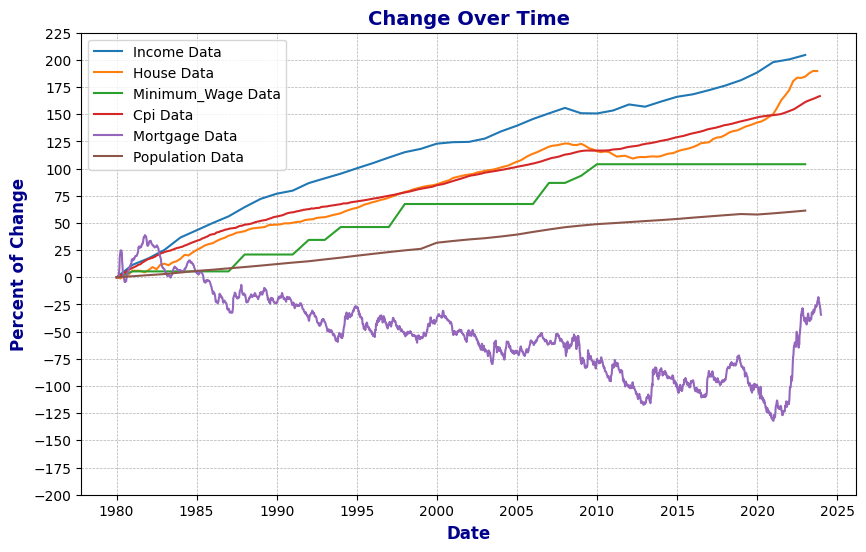

In [7]:
# Creating a visualization for income data
# Assuming df_income, df_house, and df_min_wage are your DataFrames
plt.figure(figsize=(10, 6))

# Plot each DataFrame
for key, value in data_dict.items():
    plt.plot(value['date'], value['changed'], label=f'{key.replace("_df", "").title()} Data')

plt.title("Change Over Time", fontsize=14, fontweight='bold', color='darkblue')
plt.ylabel("Percent of Change", fontsize=12, fontweight='bold', color='darkblue')
plt.xlabel("Date", fontsize=12, fontweight='bold', color='darkblue')
plt.legend()
plt.yticks(range(-200, 250, 25))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.savefig('graphs/change_over_time.png')
plt.show()


# Plot All of the Graphs

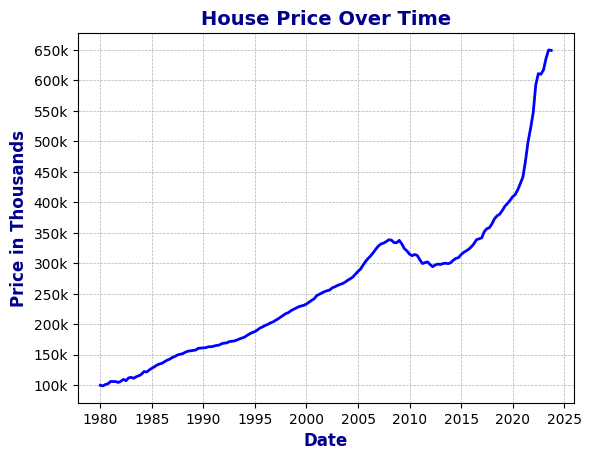

In [8]:
# Function to format y-axis labels with 'k' and 'm'
def format_y(value, tick_position):

    return f'{value}k'

plt.plot(data_dict['house_df']['date'], data_dict['house_df']['value'], linewidth=2, linestyle='-', color='blue')


plt.title("House Price Over Time", fontsize=14, fontweight='bold', color='darkblue')
plt.ylabel("Price in Thousands", fontsize=12, fontweight='bold', color='darkblue')
plt.xlabel("Date", fontsize=12, fontweight='bold', color='darkblue')
plt.yticks(range(100, 700, 50))
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(format_y))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.savefig('graphs/house_price_over_time.png')
plt.show()

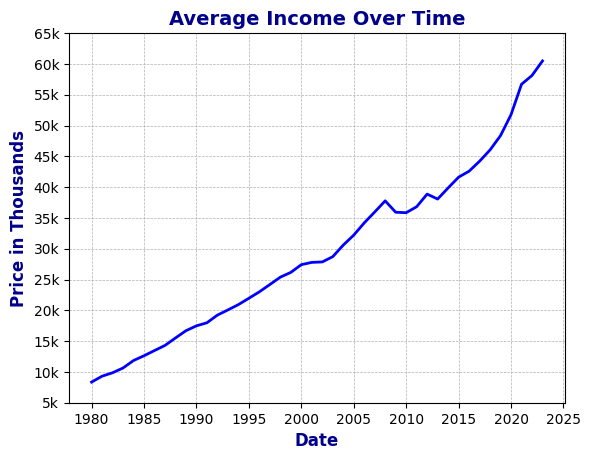

In [9]:
plt.plot(data_dict['income_df']['date'], (data_dict['income_df']['value']/1000), linewidth=2, linestyle='-', color='blue')

plt.title("Average Income Over Time", fontsize=14, fontweight='bold', color='darkblue')
plt.ylabel("Price in Thousands", fontsize=12, fontweight='bold', color='darkblue')
plt.xlabel("Date", fontsize=12, fontweight='bold', color='darkblue')
plt.yticks(range(5, 70, 5))
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(format_y))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.savefig('graphs/income_over_time.png')
plt.show()

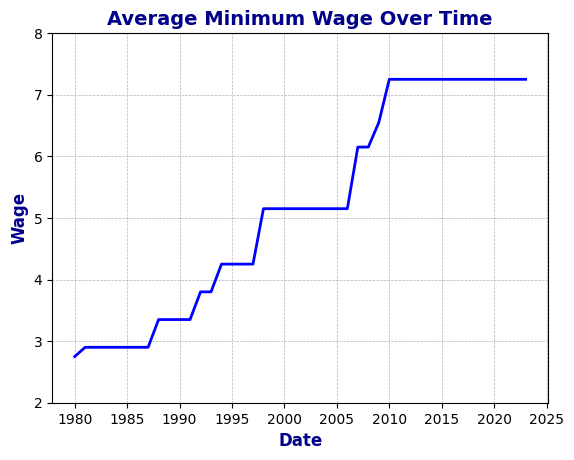

In [10]:
plt.plot(data_dict['minimum_wage_df']['date'], (data_dict['minimum_wage_df']['value']), linewidth=2, linestyle='-', color='blue')

plt.title("Average Minimum Wage Over Time", fontsize=14, fontweight='bold', color='darkblue')
plt.ylabel("Wage", fontsize=12, fontweight='bold', color='darkblue')
plt.xlabel("Date", fontsize=12, fontweight='bold', color='darkblue')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.yticks(range(2, 9, 1))
plt.savefig('graphs/min_wage_over_time.png')
plt.show()

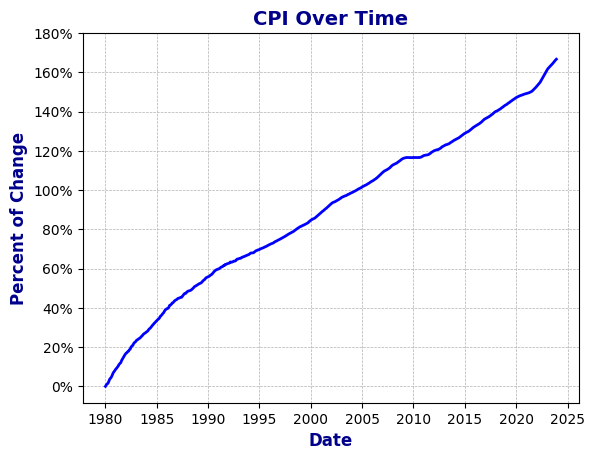

In [11]:
plt.plot(data_dict['cpi_df']['date'], (data_dict['cpi_df']['changed']), linewidth=2, linestyle='-', color='blue')

plt.title("CPI Over Time", fontsize=14, fontweight='bold', color='darkblue')
plt.ylabel("Percent of Change", fontsize=12, fontweight='bold', color='darkblue')
plt.xlabel("Date", fontsize=12, fontweight='bold', color='darkblue')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.yticks(range(0, 200, 20))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.savefig('graphs/cpi_over_time.png')
plt.show()

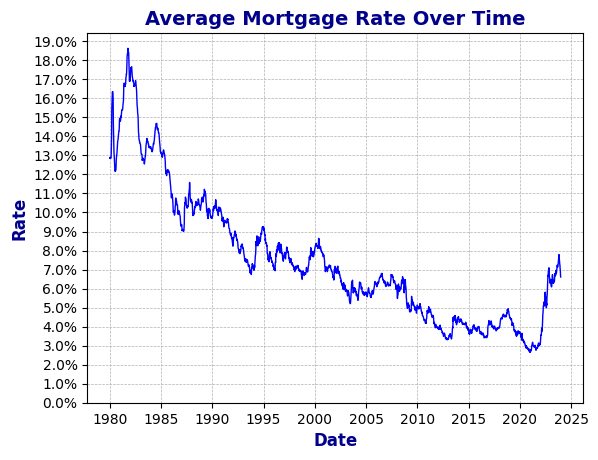

In [12]:
plt.plot(data_dict['mortgage_df']['date'], (data_dict['mortgage_df']['value']), linewidth=1, linestyle='-', color='blue')

plt.title("Average Mortgage Rate Over Time", fontsize=14, fontweight='bold', color='darkblue')
plt.ylabel("Rate", fontsize=12, fontweight='bold', color='darkblue')
plt.xlabel("Date", fontsize=12, fontweight='bold', color='darkblue')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.yticks(range(0, 20, 1))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.savefig('graphs/mortgage_rate_over_time.png')
plt.show()

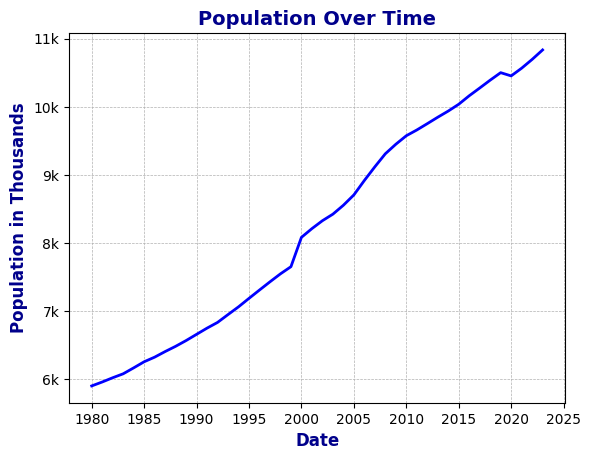

In [13]:
plt.plot(data_dict['population_df']['date'], (data_dict['population_df']['value']/1000), linewidth=2, linestyle='-', color='blue')

plt.title("Population Over Time", fontsize=14, fontweight='bold', color='darkblue')
plt.ylabel("Population in Thousands", fontsize=12, fontweight='bold', color='darkblue')
plt.xlabel("Date", fontsize=12, fontweight='bold', color='darkblue')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.yticks(range(6, 12, 1))
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(format_y))
plt.savefig('graphs/population_over_time.png')
plt.show()

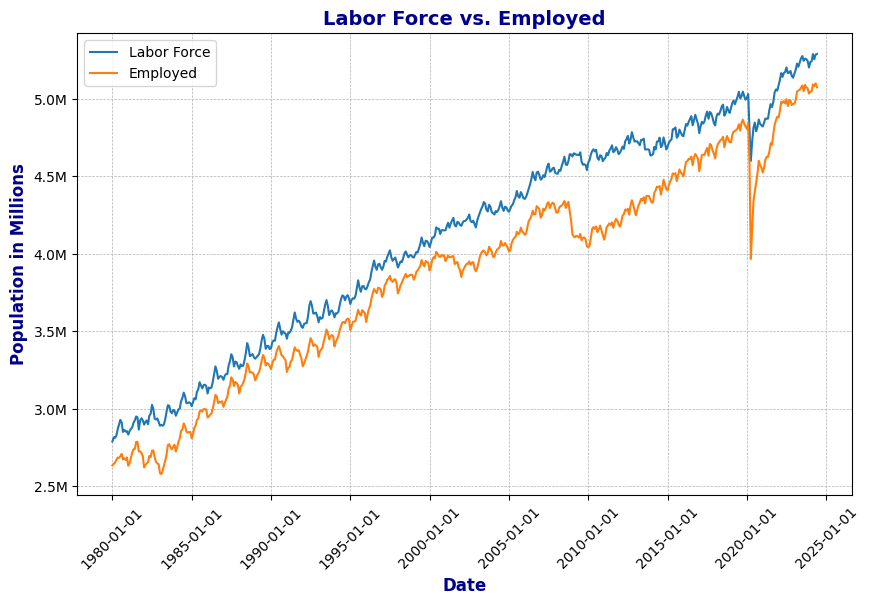

In [87]:
def format_m(value, tick_position):
    return f"{value/1000000}M"

unemployment = pd.read_csv("data/unemployment_rate.csv", index_col=0)
unemployment["Date"] = unemployment['Date'].astype("datetime64[ns]")
plt.figure(figsize=(10, 6))

plt.plot(unemployment['Date'], unemployment['Labor Force'], label="Labor Force")
plt.plot(unemployment['Date'], unemployment['Employed'], label="Employed")


plt.title("Labor Force vs. Employed", fontsize=14, fontweight='bold', color='darkblue')
plt.ylabel("Population in Millions", fontsize=12, fontweight='bold', color='darkblue')
plt.xlabel("Date", fontsize=12, fontweight='bold', color='darkblue')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

#
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(format_m))
plt.xticks(pd.date_range(start=pd.Timestamp('1980-01-01'),
                         end=pd.Timestamp('2025-01-01'),
                         freq='5YS'), rotation=45)
plt.legend()
plt.savefig("graphs/labor_force_employed.png")
plt.show()

# House Price Affordability Index
- Goal: Create an index that tracks housing affordability over time.
- Graph Type: Composite Line Chart
- Description: Plot a line chart where you calculate an affordability index based on the ratio of income to house prices. You can overlay this with mortgage rates to see how they impact affordability.
- Use Case: This index will highlight periods where housing became more or less affordable relative to income.

,date,value_h,changed_h,value_i,changed_i,affordability
0,1980-01-01,100.00,0.000000,8350.0,0.000000,0.011976
1,1981-01-01,106.21,6.128613,9309.0,11.485030,0.011409
2,1982-01-01,106.69,6.609981,9864.0,17.447002,0.010816
3,1983-01-01,112.97,12.480768,10639.0,25.303855,0.010618
4,1984-01-01,118.25,17.121982,11850.0,36.686504,0.009979


[]

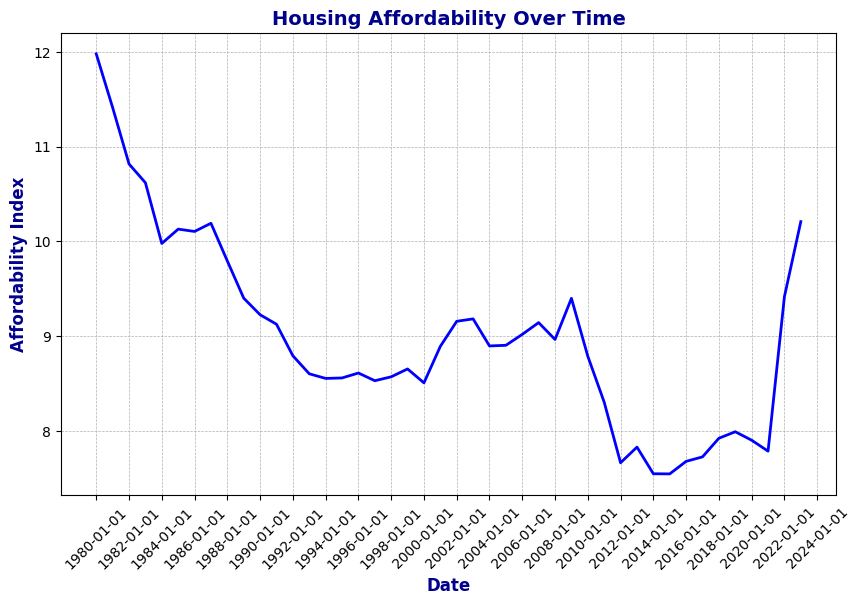

In [121]:
house_df = pd.read_csv("data/house.csv", index_col=0)
income_df = pd.read_csv("data/income.csv", index_col=0)

house_income_df = pd.merge(house_df, income_df, on='date', suffixes=('_h', '_i'))
house_income_df['affordability'] = house_income_df['value_h']/ house_income_df['value_i']
house_income_df['date'] = house_income_df['date'].astype("datetime64[ns]")

display(house_income_df.head())
plt.figure(figsize=(10, 6))

plt.plot(house_income_df['date'], house_income_df['affordability']*1000, linewidth=2, linestyle='-', color='blue')
plt.title("Housing Affordability Over Time", fontsize=14, fontweight='bold', color='darkblue')
plt.ylabel("Affordability Index", fontsize=12, fontweight='bold', color='darkblue')
plt.xlabel("Date", fontsize=12, fontweight='bold', color='darkblue')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(pd.date_range(start=pd.Timestamp('1980-01-01'),
                         end=pd.Timestamp('2025-01-01'),
                         freq='2YS'), rotation=45)
plt.savefig("graphs/housing_affordabilty.png")
plt.plot()

# Correlation Analysis
- Goal: Investigate relationships between different economic indicators.
- Graph Type: Correlation Matrix / Heatmap
- Description: Create a heatmap that shows the correlation coefficients between different pairs of indicators (e.g., income vs. house prices, minimum wage vs. CPI). This will help identify any strong positive or negative correlations.
- Use Case: Useful for understanding the degree to which one variable might influence another.

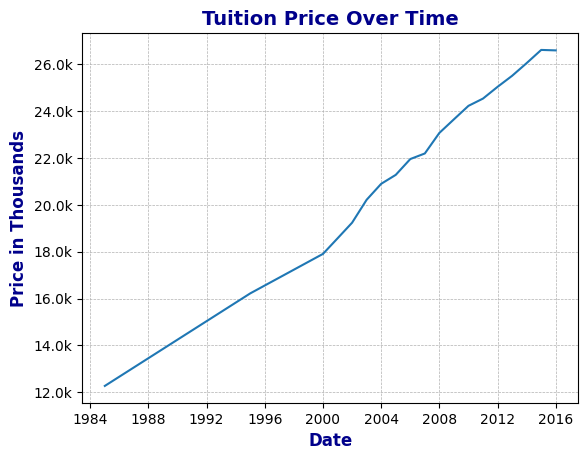

In [234]:
population_csv = pd.read_csv("data/population.csv")
mortgage_csv = pd.read_csv("data/mortgage.csv")
cpi_csv = pd.read_csv("data/cpi.csv", index_col=0)
minimum_wage_csv = pd.read_csv("data/minimum_wage.csv")
historical_tuition_csv = pd.read_csv("data/historical_tuition.csv")

historical_tuition_csv['year'] = pd.to_datetime((historical_tuition_csv['year'].str[:4]), format='%Y')
historical_tuition_csv = historical_tuition_csv.loc[(historical_tuition_csv['tuition_type'] == "4 Year Constant") & (historical_tuition_csv['type'] == "All Institutions")].reset_index(drop=True)
historical_tuition_csv.drop(columns=['tuition_type', 'type'], inplace=True)

plt.plot(historical_tuition_csv['year'], historical_tuition_csv['tuition_cost']/1000)

plt.title("Tuition Price Over Time", fontsize=14, fontweight='bold', color='darkblue')
plt.ylabel("Price in Thousands", fontsize=12, fontweight='bold', color='darkblue')
plt.xlabel("Date", fontsize=12, fontweight='bold', color='darkblue')
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(format_y))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.savefig("graphs/tuition_price_over_time.png")
plt.show()

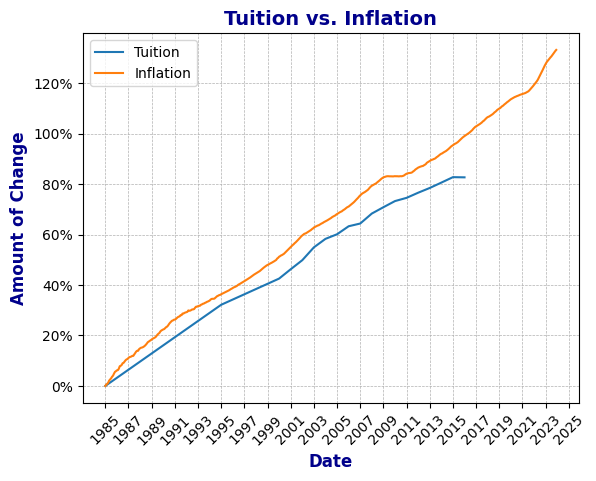

In [235]:
def start_1985(df):
    """Take a df and return the dataframe within the year 1985-2023"""
    df = df.loc[(df['date'] >= "1985-01-01") & (df['date'] <= "2023-12-31")].reset_index(drop=True)
    return df

cpi_csv = start_1985(cpi_csv)
cpi_csv.drop(columns=['changed'], inplace=True)
percent_change_column(cpi_csv)
cpi_csv['date'] = cpi_csv['date'].astype("datetime64[ns]")

historical_tuition_csv.columns = ['date', 'value']
percent_change_column(historical_tuition_csv)

plt.plot(historical_tuition_csv['date'], historical_tuition_csv['changed'], label='Tuition')
plt.plot(cpi_csv['date'], cpi_csv['changed'], label="Inflation")

plt.title("Tuition vs. Inflation", fontsize=14, fontweight='bold', color='darkblue')
plt.ylabel("Amount of Change", fontsize=12, fontweight='bold', color='darkblue')
plt.xlabel("Date", fontsize=12, fontweight='bold', color='darkblue')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(pd.date_range(start=pd.Timestamp('1985-01-01'),
                         end=pd.Timestamp('2025-01-01'),
                         freq='2YS'), rotation=45)
plt.legend()
plt.savefig("graphs/tution_vs_inflation.png")
plt.show()

# Minimum Wage and CPI
- Goal: Examine the relationship between minimum wage changes and inflation (CPI).
- Graph Type: Overlay Line Charts
- Description: Overlay the minimum wage and CPI line charts to see if minimum wage increases have kept pace with inflation.
- Use Case: Important for discussions about the real value of the minimum wage over time.


# Mortgage Rates and Housing Market Analysis
- Goal: Analyze the impact of mortgage rates on house prices and affordability.
- Graph Type: Line Chart with Dual Y-Axis
- Description: Plot mortgage rates on one axis and house prices on another to explore the relationship between the two.
- Use Case: This can help in understanding how mortgage rates influence housing market dynamics.


# Population Growth vs. Economic Indicators
- Goal: Explore how population growth correlates with economic indicators like income, house prices, and minimum wage.
- Graph Type: Scatter Plot with Trend Line
- Description: Create scatter plots that compare population growth to changes in other indicators, with trend lines to show the relationship direction and strength.
- Use Case: This can reveal how population dynamics may drive or lag behind economic